# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.patches as patches
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', 150)

# modeling libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
#from sklearn.grid_search import GridSearchCV

from collections import OrderedDict

In [15]:
df = pd.read_csv('savant_data.csv')
print(df.shape)
df.head()

(40000, 89)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,FF,2019-06-30,101.3,0.5509,6.1836,Aroldis Chapman,543877,547973,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Christian Vazquez strikes out swinging.,R,R,L,BOS,NYY,S,2.0,NaN,0,2,2019,1.1841,0.9995,-0.1572,1.5416,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183411,-4.8611,-147.1613,-10.0811,18.5249,36.4048,-15.2666,3.5,1.7,NaN,NaN,NaN,NaN,2541.0,6.6473,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.8529,NaN,NaN,0.0,1.0,0.0,0.0,NaN,92,3,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
1,CH,2019-06-30,87.2,0.5008,6.3708,Aroldis Chapman,543877,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,1,2019,-0.8553,0.1403,-0.1097,2.8397,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183325,0.2824,-126.9700,-2.5902,-9.2334,27.3368,-30.3440,3.5,1.7,NaN,NaN,NaN,NaN,2812.0,6.2259,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,54.2743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,2,Changeup,8,12,8,12,12,8,8,12,NaN,NaN
2,FF,2019-06-30,99.4,0.6354,6.2711,Aroldis Chapman,543877,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,0,2019,0.0966,1.5501,0.0167,2.6030,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183244,-1.9282,-144.5943,-8.2683,1.8397,36.6497,-8.6289,3.5,1.7,NaN,NaN,NaN,NaN,2586.0,6.4608,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,54.0394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,1,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
3,FF,2019-06-30,100.0,0.5805,6.2837,Aroldis Chapman,656308,547973,strikeout,foul_tip,NaN,NaN,NaN,NaN,5.0,Michael Chavis strikes out on a foul tip.,R,R,L,BOS,NYY,S,2.0,NaN,0,2,2019,1.0118,1.3386,0.1241,2.3864,NaN,593523.0,NaN,1,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183144,-3.7012,-145.4269,-8.6002,15.3883,35.3925,-11.1183,3.5,1.7,NaN,NaN,NaN,NaN,2596.0,6.7012,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.7990,NaN,NaN,0.0,1.0,0.0,0.0,NaN,91,3,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
4,FF,2019-06-30,98.6,0.5832,6.2344,Aroldis Chapman,656308,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,1,2019,0.2288,1.4388,-0.1114,2.2780,NaN,593523.0,NaN,1,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183100,-2.4475,-143.4481,-8.7536,3.7733,33.8462,-10.2072,3.5,1.7,NaN,NaN,NaN,NaN,2519.0,6.7412,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.7590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,2,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN


# Cleaning

In [16]:
# Cleaning for events column by combining similar events to reduce noise in eda and modeling process
# Notes: Triples may need to be labeled into something else due to lack of frequency

df['events'].replace(['fielders_choice', 'fielders_choice_out', 'double_play', 'grounded_into_double_play'], 'field_out', inplace=True)
df['events'].replace('hit_by_pitch', 'walk', inplace=True)
df['events'].replace(['force_out', 'sac_fly', 'sac_bunt'], 'field_out', inplace=True)
df['events'].replace('strikeout_double_play', 'strikeout', inplace=True)
df = df[~df['events'].isin(['caught_stealing_2b', 'field_error', 'catcher_interf', 'pickoff_1b', 'caught_stealing_home', 'pickoff_caught_stealing_2b', 'pickoff_2b'])]


In [17]:
# Cleaning for description column for same reason above

df['description'].replace(['foul_tip', 'foul_bunt', 'bunt_foul_tip'], 'foul', inplace=True)
df['description'].replace('swinging_strike_blocked', 'swinging_strike', inplace=True)
df['description'].replace('missed_bunt', 'called_strike', inplace=True)
df['description'].replace(['foul_tip', 'foul_bunt', 'bunt_foul_tip'], 'foul', inplace=True)
df['description'].replace('blocked_ball', 'ball', inplace=True)
df = df[~df['description'].isin(['pitchout'])]

In [18]:
df = df.drop(['game_date', 'spin_dir', 'spin_rate_deprecated', 
              'break_angle_deprecated', 'break_length_deprecated', 
              'game_type', 'game_year', 'on_3b', 'on_2b', 'on_1b',
              'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2',
              'umpire', 'sv_id', 'fielder_2.1', 'fielder_3',
              'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 
              'fielder_8', 'fielder_9', 'pitch_type', 'des', 'home_team', 
              'away_team','launch_speed', 'launch_angle', 'launch_speed_angle', 'hit_distance_sc',
              'pitcher.1', 'if_fielding_alignment', 'of_fielding_alignment', 
              'woba_value', 'woba_denom', 'babip_value', 'iso_value',
              'pitcher', 'batter','hit_location','bb_type', 'hc_y', 'hc_x',
              'estimated_ba_using_speedangle','estimated_woba_using_speedangle','type'], axis=1)

# Reordering columns to make it easier to read
cols = df.columns.tolist()
cols = ['player_name','balls','strikes','events', 'description', 'outs_when_up', 'zone',
        'stand', 'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'inning',
        'inning_topbot', 'release_speed', 'release_pos_x', 'release_pos_z', 'vx0', 'vy0', 'vz0',
        'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate', 
        'release_extension', 'release_pos_y', 'at_bat_number', 'pitch_number',
        'pitch_name', 'home_score', 'away_score', 'bat_score', 'fld_score',
        'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score', 'game_pk']
df = df[cols]
df.head()

,player_name,balls,strikes,events,description,outs_when_up,zone,stand,p_throws,pfx_x,pfx_z,plate_x,plate_z,inning,inning_topbot,release_speed,release_pos_x,release_pos_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,game_pk
0,Aroldis Chapman,0,2,strikeout,swinging_strike,2,13.0,R,L,1.1841,0.9995,-0.1572,1.5416,9,Bot,101.3,0.5509,6.1836,-4.8611,-147.1613,-10.0811,18.5249,36.4048,-15.2666,3.5,1.7,NaN,2541.0,6.6473,53.8529,92,3,4-Seam Fastball,8,12,8,12,12,8,8,12,565068
1,Aroldis Chapman,0,1,NaN,foul,2,5.0,R,L,-0.8553,0.1403,-0.1097,2.8397,9,Bot,87.2,0.5008,6.3708,0.2824,-126.9700,-2.5902,-9.2334,27.3368,-30.3440,3.5,1.7,NaN,2812.0,6.2259,54.2743,92,2,Changeup,8,12,8,12,12,8,8,12,565068
2,Aroldis Chapman,0,0,NaN,foul,2,5.0,R,L,0.0966,1.5501,0.0167,2.6030,9,Bot,99.4,0.6354,6.2711,-1.9282,-144.5943,-8.2683,1.8397,36.6497,-8.6289,3.5,1.7,NaN,2586.0,6.4608,54.0394,92,1,4-Seam Fastball,8,12,8,12,12,8,8,12,565068
3,Aroldis Chapman,0,2,strikeout,foul,1,5.0,R,L,1.0118,1.3386,0.1241,2.3864,9,Bot,100.0,0.5805,6.2837,-3.7012,-145.4269,-8.6002,15.3883,35.3925,-11.1183,3.5,1.7,NaN,2596.0,6.7012,53.7990,91,3,4-Seam Fastball,8,12,8,12,12,8,8,12,565068
4,Aroldis Chapman,0,1,NaN,foul,1,5.0,R,L,0.2288,1.4388,-0.1114,2.2780,9,Bot,98.6,0.5832,6.2344,-2.4475,-143.4481,-8.7536,3.7733,33.8462,-10.2072,3.5,1.7,NaN,2519.0,6.7412,53.7590,91,2,4-Seam Fastball,8,12,8,12,12,8,8,12,565068


In [68]:
# We will drop row 987 because mose of the column entries are null and can't be salvaged
df = df[df['release_speed'].notnull()]

# Dropping rows with null effective speed values. Subject to change in future iterations
df = df[df['effective_speed'].notnull()]

# dropping rows where pitch type is unknown (note: consider doing the reverse of what we did for release_spin_rate)
# dropping knuckle ball, forkball, and euphus pitches due to how rare they are
df = df[df['pitch_name'].notnull()]
df = df[~df['pitch_name'].isin(['Eephus', 'Forkball', 'Knuckle Ball'])]

# imputing release_spin_rate with mean values grouped by pitch_name (i.e. curve balls spin the fastest compared to other pitches)
df['release_spin_rate'] = df['release_spin_rate'].fillna(df.groupby('pitch_name')['release_spin_rate'].transform('mean'))

# imputing events with 'nothing' to represent when the batter remains at bat after the result of the at bat attempt
df['events'] = df['events'].fillna('no_event')

# defining response variable that determines if the batter got on base or not (1 for strikes/outs 0 for balls or hits on base)
df['strike_result'] = df['description'].isin(['hit_into_play', 'called_strike', 'swinging_strike', 'foul']) * 1

# confirming that there are no more null values
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

# EDA

The goal is to identify which factors determine a successful pitcher so that the Blue Jays can make cost efficient trades to improve their pitching roster

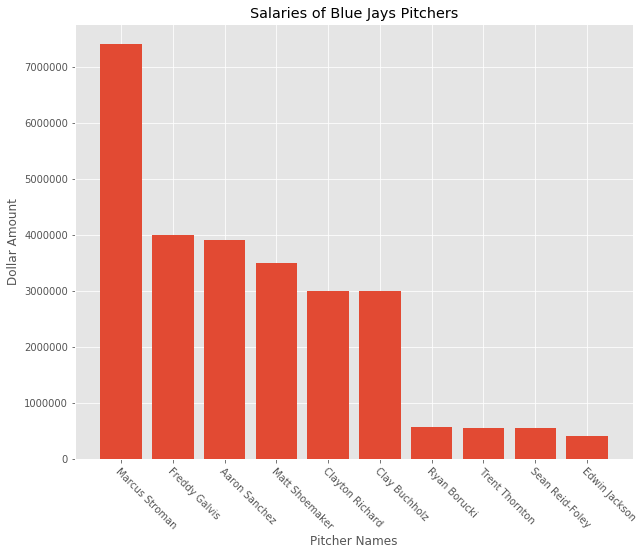

In [20]:
bluejay_pitcher_salary = {'Freddy Galvis':4000000, 
                         'Marcus Stroman':7400000, 
                         'Aaron Sanchez':3900000,
                         'Clayton Richard':3000000,
                         'Trent Thornton':555000,
                         'Sean Reid-Foley':555000,
                         'Matt Shoemaker':3500000,
                         'Clay Buchholz':3000000,
                         'Ryan Borucki':565200,
                         'Edwin Jackson':411792}

test = dict(sorted(bluejay_pitcher_salary.items(), key=lambda x: x[1], reverse=True))

# plot
fig, ax = plt.subplots(figsize=(10,8))
plt.title('Salaries of Blue Jays Pitchers')
plt.xlabel('Pitcher Names')
plt.ylabel('Dollar Amount')
plt.bar(*zip(*sorted(bluejay_pitcher_salary.items(), key=lambda x: x[1], reverse=True)))
plt.xticks(rotation=45)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor");

In [67]:
starting_pitchers_names = df.player_name.loc[df['inning']==1].unique()
starting_pitchers = (df.loc[df.player_name.isin(starting_pitchers_names)]
                        .groupby('player_name')
                        .agg({'release_speed':'mean',
                              'strike_result':'mean',
                              'pitch_name': lambda x:x.value_counts().index[0]})
                        .sort_values(by='strike_result', ascending=False)
                        .rename({'strike_result': 'strike_ratio'}, axis='columns'))
best_pitchers = starting_pitchers.head(3)
worst_pitchers = starting_pitchers.tail(3)

print(best_pitchers)
print('\n')
print(worst_pitchers)

              release_speed  strike_ratio       pitch_name
player_name                                               
Max Scherzer      89.140670      0.708134  4-Seam Fastball
Bryse Wilson      92.304938      0.691358  4-Seam Fastball
Noe Ramirez       82.668831      0.688312        Curveball


                     release_speed  strike_ratio       pitch_name
player_name                                                      
Tanner Anderson          91.111712      0.468468           Sinker
Odrisamer Despaigne      88.869118      0.455882  4-Seam Fastball
Mike Clevinger           89.707692      0.442308  4-Seam Fastball


Z:\Users\Don\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


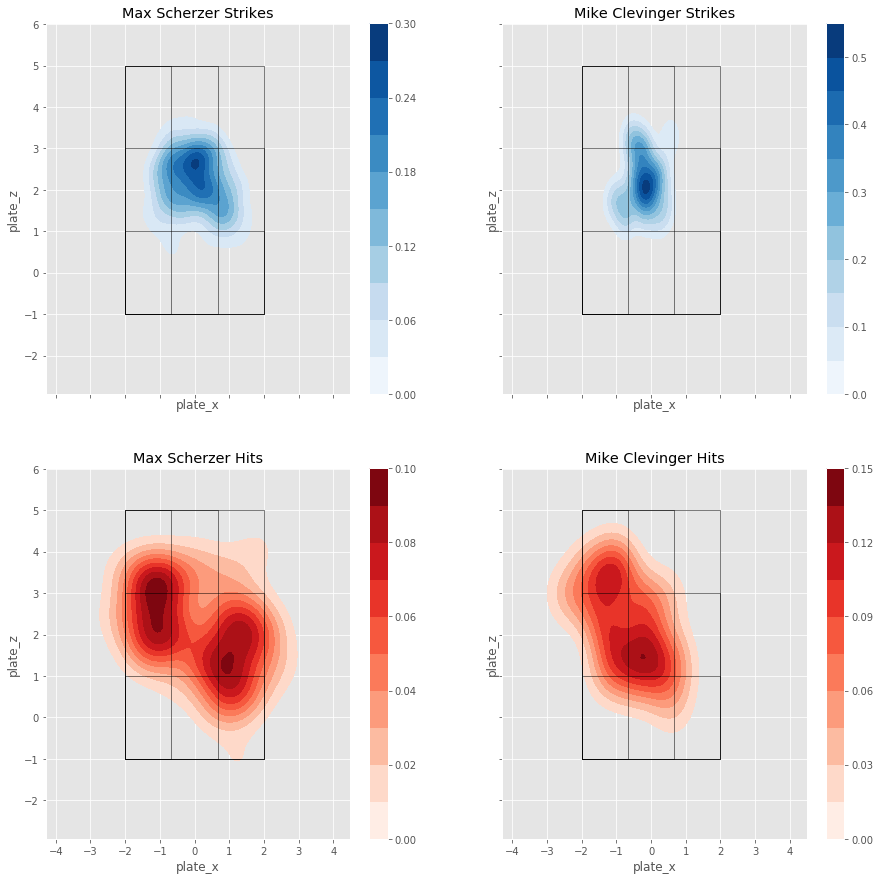

In [55]:
scherzer_strikes = df.copy()[(df['player_name']=='Max Scherzer')  & (df.strike_result==1)]
clevinger_strikes = df.copy()[(df['player_name']=='Mike Clevinger')  & (df.strike_result==1)]
scherzer_hits = df.copy()[(df['player_name']=='Max Scherzer') & (df.strike_result==0)]
clevinger_hits = df.copy()[(df['player_name']=='Mike Clevinger') & (df.strike_result==0)]

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,15))

for i in range(0,2):
    for j in range(0,2):
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 6, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 4, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 2, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), (4/3), 6, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), (8/3), 6, fill=False, edgecolor='black'))

sns.kdeplot(scherzer_strikes['plate_x'] , scherzer_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[0,0], cbar=True).set_title('Max Scherzer Strikes')
sns.kdeplot(clevinger_strikes['plate_x'] , clevinger_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[0,1], cbar=True).set_title('Mike Clevinger Strikes')

sns.kdeplot(scherzer_hits['plate_x'] , scherzer_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[1,0], cbar=True).set_title('Max Scherzer Hits')
sns.kdeplot(clevinger_hits['plate_x'] , clevinger_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[1,1], cbar=True).set_title('Mike Clevinger Hits');

The best pitcher(Max) seems to have a larger distribution that spreads across zones 4,5,6 whereas the worst pitcher(Mike) has a smaller distribution concentrated around zone 5. This may be a major contributing factor towards Max's success as a pitcher. Note that the difference between the bottom distributions (pitches that got hit) may be due to different type of pitches or fatigue. This may require more investigation.

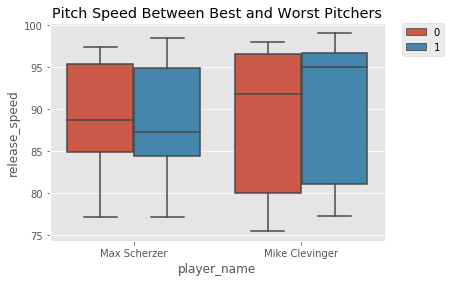

In [53]:
# Distribution of release speeds between the best and worst pitchers
pitchers = df[df['player_name'].isin(['Max Scherzer', 'Mike Clevinger'])]
sns.boxplot('player_name','release_speed', data=pitchers, hue='strike_result',)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0) # 0 means hit, 1 means strike
plt.title('Pitch Speed Between Best and Worst Pitchers');

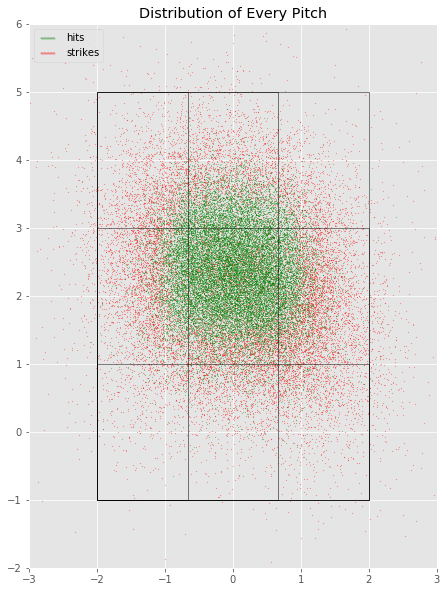

In [37]:
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.add_patch(patches.Rectangle((-2, -1), 4, 6, fill=False, edgecolor='black'))
ax1.add_patch(patches.Rectangle((-2, -1), 4, 4, fill=False, edgecolor='black'))
ax1.add_patch(patches.Rectangle((-2, -1), 4, 2, fill=False, edgecolor='black'))
ax1.add_patch(patches.Rectangle((-2, -1), (4/3), 6, fill=False, edgecolor='black'))
ax1.add_patch(patches.Rectangle((-2, -1), (8/3), 6, fill=False, edgecolor='black'))
plt.axis('scaled')
strike = plt.scatter(x=df['plate_x'][df['strike_result']==0], y=df['plate_z'][df['strike_result']==0], data=df, marker='.', c='r', alpha=0.3, s=2)
hits = plt.scatter(x=df['plate_x'][df['strike_result']==1], y=df['plate_z'][df['strike_result']==1], data=df, marker='.', c='g', alpha=0.3, s=2)
plt.legend([hits, strike], ['hits', 'strikes'], loc='upper left', scatterpoints=30)
plt.ylim(-2,6)
plt.xlim(-3,3)
plt.title('Distribution of Every Pitch')

plt.show()

Z:\Users\Don\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


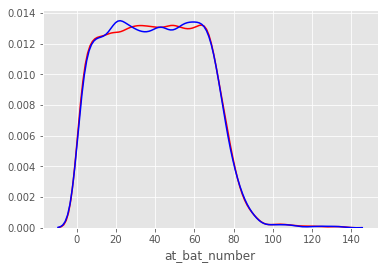

In [28]:
# release_pos_x
sns.distplot(df['at_bat_number'][df['strike_result']==1], bins=50, color='r', hist=False ) 
sns.distplot(df['at_bat_number'][df['strike_result']==0], bins=50, color='b', hist=False ) 

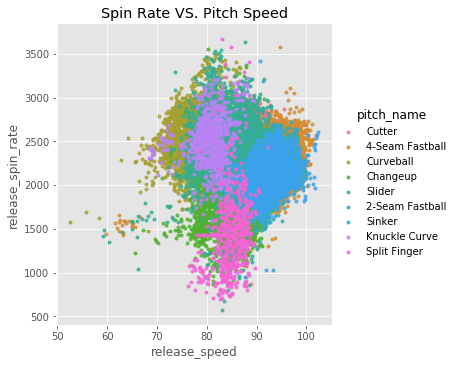

In [35]:
sns.lmplot(x='release_speed', y='release_spin_rate', data=df, hue='pitch_name', markers='.', fit_reg=False)
plt.title('Spin Rate VS. Pitch Speed');

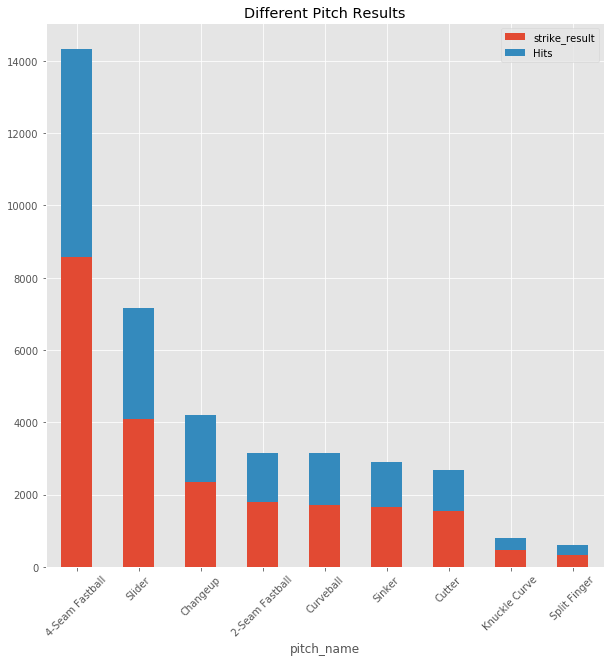

In [34]:
#note: consider placing percentages in the visualization (or maybe pie graphs)
pitch_type_result = (df.groupby('pitch_name')
                       .agg({'events':'count','strike_result':'sum'})
                       .sort_values(by='strike_result', ascending=False))
pitch_type_result['Hits'] = pitch_type_result['events'] - pitch_type_result['strike_result']
pitch_type_result.drop('events', axis='columns', inplace=True)
pitch_type_result.plot(kind='bar', stacked=True, figsize=(10,10))
plt.xticks(rotation=45)
plt.title('Different Pitch Results');


''

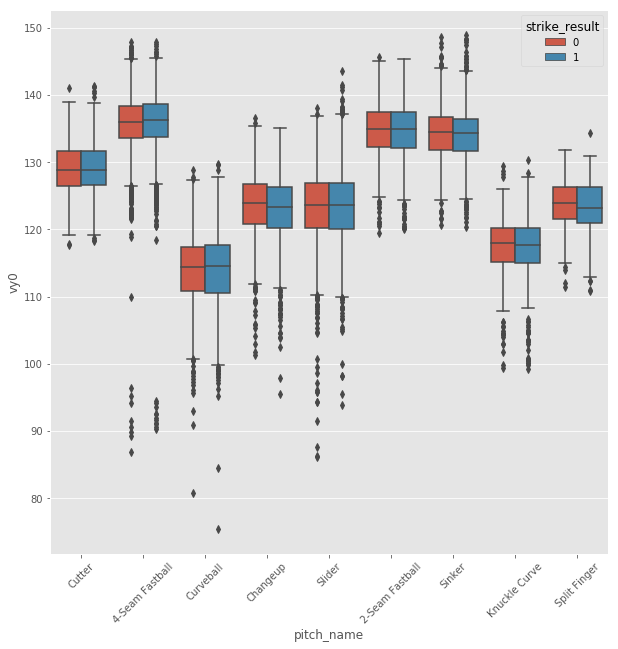

In [31]:
# Seems like the type of pitch doesn't have a heavy influence on whether the batter is struck out
df2 = df.copy()
plt.figure(figsize=[10,10])
df2['vy0'] = -df2['vy0']
sns.boxplot(x='pitch_name', y='vy0', hue='strike_result', data=df2)
plt.xticks(rotation=45)
;

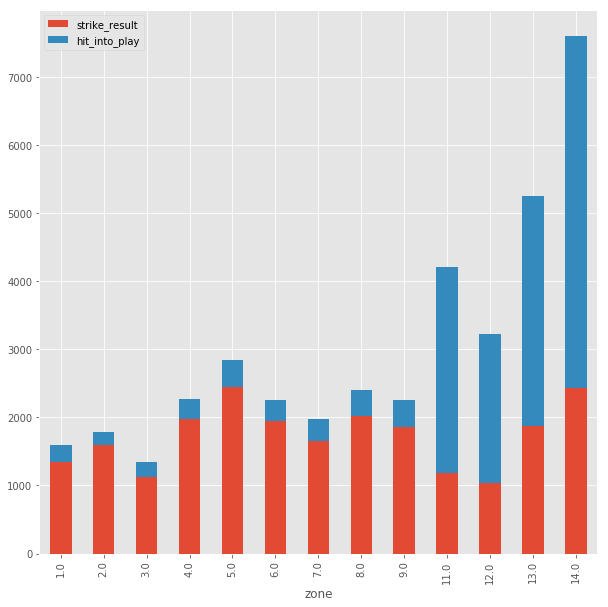

In [32]:
zones = df.groupby('zone').agg({'pitch_number':'count',
                                'strike_result':'sum'})

zones['hit_into_play'] = zones['pitch_number'] - zones['strike_result']
zones = zones.drop('pitch_number', axis=1)
zones.plot(kind='bar', stacked=True, figsize=(10,10));
